# Explore all scenario results

This notebook reproduces the analysis of Section 4.2.1 to Section 4.2.4 with some additional visualizations.

### Setup
Follow the instructions `README.md` to download and setup the data files.

In [1]:
evaluation_part1_file = '../data/output/evaluation_part1/evaluation_part1.csv'
evaluation_part1_qs_file = '../data/output/evaluation_part1_qs/evaluation_part1_qs.csv'
plot_output_path = '../plots/'

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
font_scale=2.2
sns.set_context("notebook", font_scale=font_scale)
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
# Set "True" to output tables in tex-style
print_latex = False

In [4]:
def num_init_labeled(x):
    if x['initial_pool_strategy'] == 'Pp':
        return 0.1 * x['num_points']
    elif x['initial_pool_strategy'] == 'Pn':
        return 20
    elif x['initial_pool_strategy'] == 'Pa':
        return x['num_dimensions'] + 5
    else:
        return 0        

In [5]:
qs_types = {
    'data': ['MinimumMarginQs', 'ExpectedMinimumMarginQs', 'ExpectedMaximumEntropyQs', 'MinimumLossQs'],
    'model': ['HighConfidenceQs', 'DecisionBoundaryQs', 'NeighborhoodBasedQs', 'BoundaryNeighborCombinationQs'],
    'random': ['RandomQs', 'RandomOutlierQs']
}
qs_types = {y: x for x in qs_types for y in qs_types[x] }

In [6]:
def pretty_plot(title="Plot", f=sns.catplot, plot_size=(12, 5), pretty_order=None, pretty_hue_order=None, **kwargs):
    if 'hue' in kwargs:
        kwargs['hue_order'] = order[kwargs['hue']] if pretty_hue_order is None else pretty_hue_order
    if 'x' in kwargs and f != sns.scatterplot and f != sns.pointplot:
        kwargs['order'] = order[kwargs['x']] if pretty_order is None else pretty_order
    fig, ax = plt.subplots()
    _ = fig.set_size_inches(plot_size)
    g = f(ax=ax, **kwargs)
    if type(g) == sns.axisgrid.FacetGrid:
        plt.close(g.fig)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return fig

In [7]:
def load_csv_file(f):
    df = pd.read_csv(f)
    df.split_strategy = df.split_strategy.apply(str)
    # merge kde_errors
    df.exit_code = df.exit_code.apply(lambda x: 'kde_error' if x in ["OneClassActiveLearning.QueryStrategies.KDEException", "PyCall.PyError"] else x)
    df.exit_code = df.exit_code.apply(lambda x: 'missing_label' if x == "OneClassActiveLearning.QueryStrategies.MissingLabelTypeException" else x)
    # Add learning scenario
    df['model_type'] = df['model'].apply(lambda x: 'SSAD' if 'SSAD' in x else 'SVDD')
    df['qs_type'] = df['qs'].apply(lambda x: qs_types[x])
    df['scenario'] = df[['split_strategy', 'initial_pool_strategy']].astype(str).apply(lambda x: '-'.join(x), axis=1)
    df['num_init_labeled'] = df.apply(num_init_labeled, axis=1)
    df_success = df.query('exit_code == "success"').reset_index(drop=True)
    return df, df_success

In [8]:
df, df_success = load_csv_file(evaluation_part1_file)

Specify plot order.

In [9]:
order = {
    'model_type': ['SVDD', 'SSAD'],
    'qs_type': ['data', 'model', 'random'],
    'qs': ['MinimumMarginQs', 'ExpectedMinimumMarginQs', 'ExpectedMaximumEntropyQs', 'MinimumLossQs', 'HighConfidenceQs', 'DecisionBoundaryQs', 'NeighborhoodBasedQs', 'BoundaryNeighborCombinationQs', 'RandomQs', 'RandomOutlierQs'],
    'data_set': ['Annthyroid', 'Cardiotocography', 'HeartDisease', 'Hepatitis', 'PageBlocks', 'Parkinson', 'Pima', 'SpamBase', 'Stamps'],
    'model': ['VanillaSVDD', 'SVDDneg', 'SSAD_0.1', 'SSAD_0.5', 'SSAD'],
    'split_strategy': ['Sh', 'Sf', 'Si'],
    'initial_pool_strategy': ['Pu', 'Pp', 'Pn', 'Pa']
}
pretty_names = {
                'AEQ': {'m_average_end_quality': 'MCC', 'k_average_end_quality': 'kappa', 'auc_average_end_quality': 'AUC', 'pauc_average_end_quality': 'PAUC'},
                'AEQ-M': {'m_average_end_quality': 'MCC-AEQ', 'k_average_end_quality': 'kappa-AEQ', 'auc_average_end_quality': 'AUC-AEQ', 'pauc_average_end_quality': 'PAUC-AEQ'},
                'SQ-M': {'m_start_quality': 'MCC-SQ', 'k_start_quality': 'kappa-SQ', 'auc_start_quality': 'AUC-SQ', 'pauc_start_quality': 'PAUC-SQ'},
                'MCC': {'m_start_quality': 'SQ', 'm_end_quality': 'EQ', 'm_average_end_quality': 'AEQ', 'm_ramp_up': 'RU'},
                'qs': {
                    'MinimumMarginQs': '$\tau_\text{MM}$',
                    'ExpectedMinimumMarginQs': '$\tau_\text{EMM}$',
                    'ExpectedMaximumEntropyQs': '$\tau_\text{EME}$',
                    'MinimumLossQs': '$\tau_\text{ML}$',
                    'HighConfidenceQs': '$\tau_\text{HC}$',
                    'DecisionBoundaryQs': '$\tau_\text{DB}$',
                    'NeighborhoodBasedQs': '$\tau_\text{NB}$',
                    'BoundaryNeighborCombinationQs': '$\tau_\text{BNC}$',
                    'RandomQs': '$\tau_\text{rand}$',
                    'RandomOutlierQs': '$\tau_\text{rand-out}$',
                  },
}

## Analysis

Data set statistics

In [10]:
df.groupby(["data_set"]).max()[["num_points", "num_dimensions"]]

,num_points,num_dimensions
data_set,,
Annthyroid,2000.0,21.0
Cardiotocography,1734.0,21.0
HeartDisease,157.0,13.0
Hepatitis,70.0,19.0
PageBlocks,2000.0,10.0
Parkinson,50.0,22.0
Pima,526.0,8.0
SpamBase,2000.0,57.0
Stamps,325.0,9.0


### Comparison of Evaluation Metrics (Section 4.2.1)

In [11]:
res = df_success[["m_average_end_quality", "k_average_end_quality", "auc_average_end_quality", "pauc_average_end_quality"]].rename(columns=pretty_names['AEQ']).corr('pearson')
print(res.to_latex()) if print_latex else res

,MCC,kappa,AUC,PAUC
MCC,1.000000,0.975625,0.382335,0.527243
kappa,0.975625,1.000000,0.375835,0.563600
AUC,0.382335,0.375835,1.000000,0.721817
PAUC,0.527243,0.563600,0.721817,1.000000


Inspect correlation of mcc and pauc

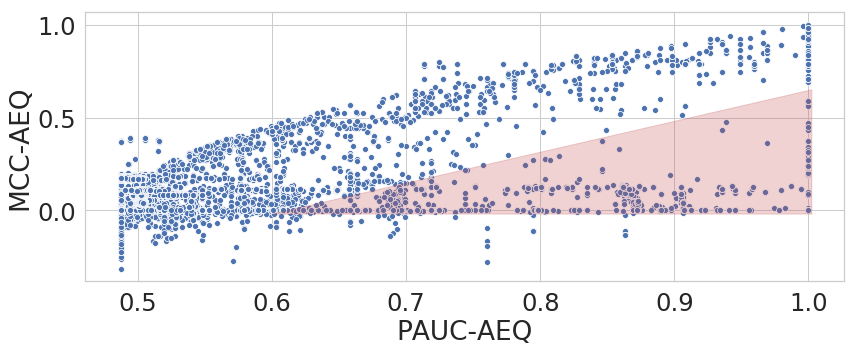

In [12]:
f = pretty_plot(title=f'PAUC vs. MCC', 
                x="pauc_average_end_quality", 
                y="m_average_end_quality", 
                data=df_success,
                f = sns.scatterplot,
                legend = None)
f.axes[0].set_xlabel("PAUC-AEQ")
f.axes[0].set_ylabel("MCC-AEQ")
f.tight_layout()
t1 = plt.Polygon([[0.6, -0.02], [1.0025, 0.65], [1.0025, -0.02]], alpha=0.25, color=sns.color_palette()[3], joinstyle='round')
plt.gca().add_patch(t1)
f.savefig(f'{plot_output_path}/eval_comp_pauc_vs_mcc.pdf')


### Comparison of Split Strategies (Section 4.2.2)

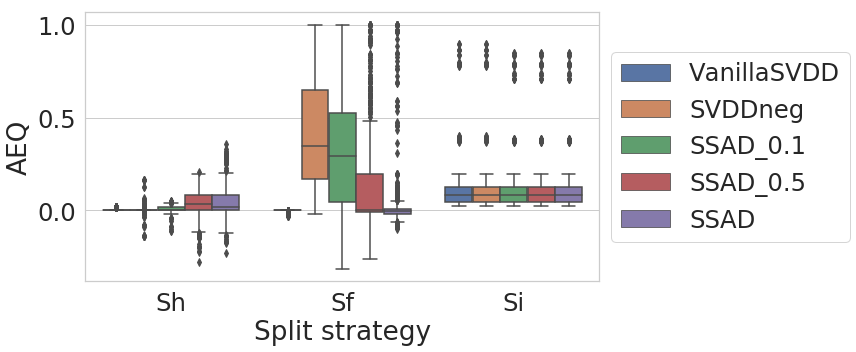

In [13]:
f = pretty_plot(title=f'Comparison of split strategies', 
                x="split_strategy", 
                y="m_average_end_quality", 
                hue="model",
                data=df_success, 
                kind="box")
f.axes[0].set_xlabel('Split strategy');
f.axes[0].set_ylabel('AEQ')
f.tight_layout()
f.savefig(f'{plot_output_path}/eval_comp_split_strategies.pdf')

Visualize fluctuation with Average Quality Gain and Average Quality Loss by model.

Text(0,0.5,'AQG')

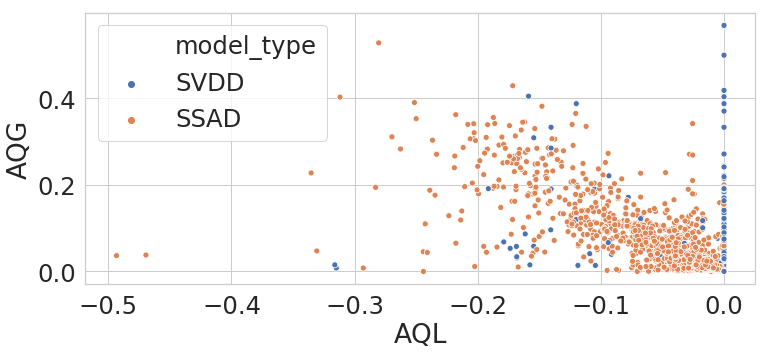

In [14]:
f = pretty_plot(title=f'Comparison of initial pool strategies', 
            x="m_average_loss", 
            y="m_average_gain", 
            hue="model_type", 
            data=df_success.query('split_strategy == "Sf"'), 
            f=sns.scatterplot)
f.axes[0].set_xlabel('AQL')
f.axes[0].set_ylabel('AQG')

### Comparison of Initial Pool Strategies (Section 4.2.3)

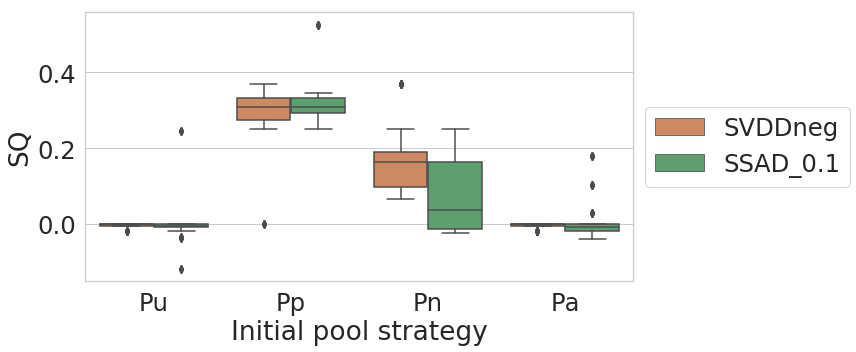

In [15]:
d = df_success.query('split_strategy == "Sf" and data_set not in ["Hepatitis", "Parkinson"] and model in ["SVDDneg", "SSAD_0.1"]').reset_index(drop=True)
f = pretty_plot(title=f'Comparison of initial pool strategies', 
            x="initial_pool_strategy", 
            y="m_start_quality", 
            hue="model", 
            data=d, 
            kind="box",
            pretty_order=['Pu', 'Pp', 'Pn', 'Pa'],
            pretty_hue_order=['SVDDneg', 'SSAD_0.1'],
            palette=sns.color_palette()[1:])
f.axes[0].set_xlabel('Initial pool strategy')
f.axes[0].set_ylabel('SQ')
f.tight_layout()
f.savefig(f'{plot_output_path}/eval_comp_initial_pool_strategies.pdf')

In [16]:
res = df_success.query('data_set in ["Annthyroid", "HeartDisease"] ' +
                       'and split_strategy in ["Sf"] ' +
                       'and model == "SVDDneg" ' +
                       'and initial_pool_strategy in ["Pp", "Pn"]').\
    groupby(["data_set", "initial_pool_strategy"]).\
    mean()[["num_points", "num_init_labeled", "m_start_quality", "m_average_end_quality"]].\
    rename(columns=pretty_names['MCC']).\
    reset_index().\
    round(2)
res.num_points = res.num_points.round().astype(int)
res.num_init_labeled = res.num_init_labeled.round().astype(int)
res.columns = ['Data set', 'Initial setup', 'Observations', 'Initially labeled', 'SQ', 'AEQ']
print(res.to_latex(index=False)) if print_latex else res

,Data set,Initial setup,Observations,Initially labeled,SQ,AEQ
0,Annthyroid,Pn,2000,20,0.08,0.14
1,Annthyroid,Pp,2000,200,0.30,0.34
2,HeartDisease,Pn,157,20,0.33,0.65
3,HeartDisease,Pp,157,16,0.33,0.66


### Comparison of query strategies (Section 4.2.4)

Load experiments with 5 resamples of the initial pool.

In [17]:
_, df_filtered = load_csv_file(evaluation_part1_qs_file)

Compute correlation between summary statistics.

In [18]:
target_metrics = ['m_end_quality', 'm_ramp_up', 'm_quality_range',
       'm_average_end_quality', 'm_average_quality_change', 'm_average_gain',
       'm_average_loss', 'm_learning_stability', 'm_ratio_of_outlier_queries']

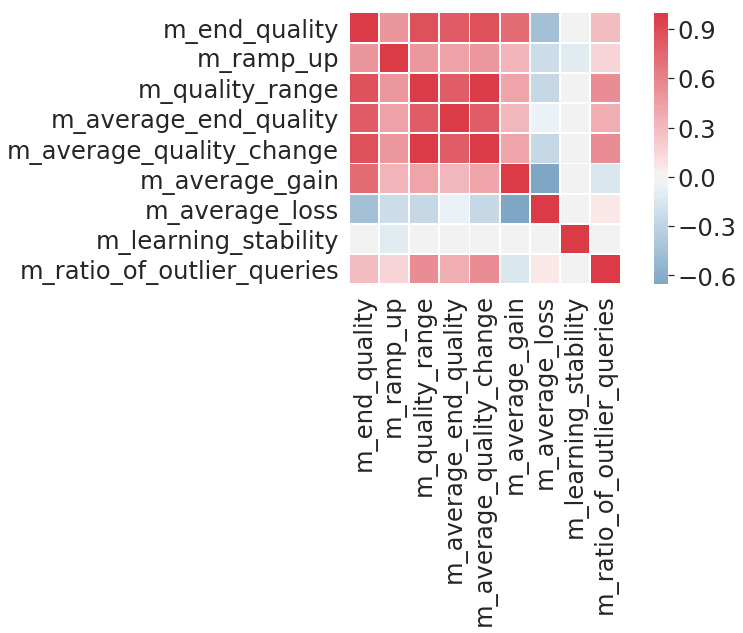

In [19]:
corr = df_filtered[target_metrics]
corr = corr.corr()
cmap = sns.diverging_palette(240, 10, as_cmap=True)
_ = pretty_plot('Correlation Qs', f=sns.heatmap, data=corr, center=0, square=True, cmap=cmap, linewidths=1)

In [20]:
# For other metrics replace this value, e.g., with "m_average_end_quality"
metric = "m_quality_range"
res = df_filtered.groupby(["data_set", "qs"]).mean()[[metric]].reset_index().pivot(index='data_set', columns = 'qs')[[metric]]
res = res.T.reset_index(level=0, drop=True).T
res = res[[x for x in order['qs'] if x in res.columns]].round(decimals=2)
if print_latex:
    res.columns = [pretty_names['qs'][x] for x in res.columns]
res = res.reset_index()
res.columns = ['Data set'] + res.columns[1:].values.tolist()
print(res.to_latex(escape=False, na_rep='-', index=False)) if print_latex else res

,Data set,MinimumMarginQs,ExpectedMinimumMarginQs,ExpectedMaximumEntropyQs,MinimumLossQs,HighConfidenceQs,DecisionBoundaryQs,NeighborhoodBasedQs,BoundaryNeighborCombinationQs,RandomQs,RandomOutlierQs
0,Annthyroid,NaN,NaN,NaN,NaN,0.06,0.05,0.04,0.04,0.11,0.07
1,Cardiotocography,NaN,NaN,NaN,NaN,0.21,0.22,0.25,0.06,0.06,0.33
2,HeartDisease,0.05,0.08,0.31,0.36,0.34,0.34,0.43,0.19,0.37,0.66
3,Hepatitis,0.41,0.41,0.41,NaN,0.41,0.41,0.41,0.41,0.41,0.41
4,PageBlocks,0.07,0.08,0.08,0.08,0.00,0.00,0.01,0.04,0.04,0.05
5,Pima,0.12,0.13,0.13,0.36,0.24,0.22,0.19,0.16,0.24,0.87
6,SpamBase,NaN,NaN,NaN,NaN,0.10,0.10,0.17,0.03,0.09,0.08
7,Stamps,0.01,0.03,0.08,0.57,0.60,0.60,0.59,0.34,0.36,0.06


Inspect the ratio of outliers queried per model and query startegy.

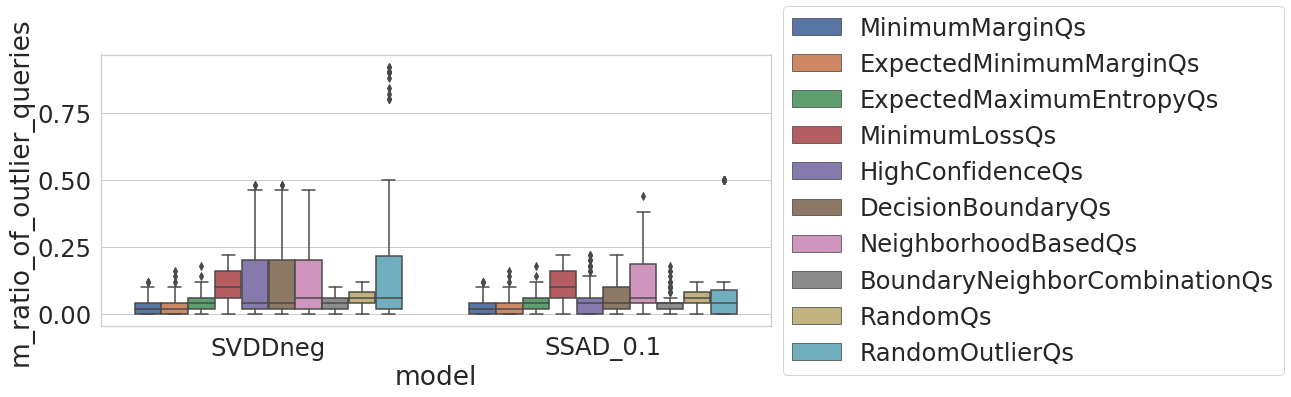

In [21]:
f = pretty_plot(title=f'Init strategy vs ratio of outliers', 
                x="model", 
                y="m_ratio_of_outlier_queries",
                hue="qs",
                data=df_filtered,
                pretty_order=['SVDDneg', 'SSAD_0.1'],
                kind="box")